# Advanced Deep Learning Midterm

Karma El Gendy


# Lecture Code (Deep Autoencoder)

### I chose the Deep Autoencoder from the lecture as it gave the best results among the 3 models. 

The original model is a deep autoencoder that consists of an encoder network followed by a decoder network. The encoder network comprises three dense layers with **128, 64, and 32** units respectively, each using the **ReLU activation function**, gradually reducing the dimensionality of the input image. 

An additional **dense layer with 18 units** and **ReLU activation** is inserted between the encoder and decoder, serving as a bottleneck layer to capture essential features.

The decoder network mirrors the encoder architecture, gradually expanding the dimensionality back to the original **image size of 784 units.** 

The model is trained using the **mean squared error loss function** and **Adam optimizer.** 


# Improved Code (Variational Autoencoder)

## Importing Libraries

In [1]:
# Importing necessary libraries
import keras
from keras import layers
from keras.datasets import fashion_mnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Sampling Layer

**Sampling Layer**:
   - This layer samples from the **Gaussian distribution** represented by `mean` and `log_var`.
   - It introduces **stochasticity** into the model, allowing for diverse outputs during training and inference.


In [2]:
# Define Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        epsilon = keras.backend.random_normal(shape=keras.backend.shape(mean))
        return mean + keras.backend.exp(0.5 * log_var) * epsilon

## Define encoder 

**Encoder**:
   - The encoder network maps input data to a latent space representation.
   - It consists of densely connected layers with **ReLU** activation functions.
   - The encoder outputs two vectors: `mean` and `log_var`, representing the parameters of a Gaussian distribution.


In [3]:
# Define Encoder
latent_dim = 10  # Increase latent dimensionality
encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(512, activation='relu')(encoder_inputs)  # Increase capacity
x = layers.Dense(256, activation='relu')(x)  # Additional layer with 256 neurons
x = layers.Dense(128, activation='relu')(x)
mean = layers.Dense(latent_dim)(x)
log_var = layers.Dense(latent_dim)(x)
encoder_outputs = Sampling()([mean, log_var])
encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")

**Introduction of Latent Space Regularization:**

In the original deep autoencoder, the encoder produces a deterministic latent representation of the input data. However, in the VAE, the encoder outputs not only the mean but also the log variance of a **Gaussian distribution**, which represents the latent space. This introduces a form of regularization to the latent space, forcing it to follow a specific distribution (Gaussian distribution).

## Define decoder

**Decoder**:
   - Reconstructs input data from the sampled **latent representation.**
   - It also consists of densely connected layers, with **ReLU** activation functions.
   - The final layer uses a **sigmoid activation function** to produce pixel values.


In [4]:
# Define Decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(decoder_inputs)
x = layers.Dense(256, activation='relu')(x)  # Additional layer with 256 neurons
x = layers.Dense(512, activation='relu')(x)  # Increase capacity
outputs = layers.Dense(784, activation='sigmoid')(x)
decoder = keras.Model(decoder_inputs, outputs, name="decoder")

## Define VAE model

In [5]:
# Define VAE model
vae_outputs = decoder(encoder(encoder_inputs))
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")

## Define VAE loss layer

**Custom Loss Function Layer**:
   - Combines reconstruction loss and **KL divergence loss.**
   - Reconstruction loss measures the difference between input data and reconstructed data.
   - **KL divergence** loss encourages the latent distribution to approximate a **unit Gaussian.**
   - The total loss is the sum of these components, scaled by the number of pixels.

In [6]:
# Define Custom Loss Function Layer
class VAELossLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        
    def call(self, inputs):
        inputs, mean, log_var, reconstructed = inputs
        inputs_flat = tf.reshape(inputs, [-1, 784])
        reconstructed_flat = tf.reshape(reconstructed, [-1, 784])
        reconstruction_loss = keras.losses.binary_crossentropy(inputs_flat, reconstructed_flat) * 784
        kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        return total_loss

While the original deep autoencoder uses **mean squared error (MSE)** as the loss function for reconstruction, the VAE employs a custom loss function that combines **reconstruction loss**  with **KL divergence loss**. The KL divergence loss encourages the learned latent space to approximate a unit Gaussian distribution, thereby regularizing the model and enabling better generalization.

- The total loss is adjusted by the scaling factor **784** (the number of pixels in the input images).

In [7]:
# Create an instance of the VAE loss layer
vae_loss_layer = VAELossLayer()([encoder_inputs, mean, log_var, vae_outputs])

# Combine the models and loss
vae.add_loss(vae_loss_layer)

## Compile the VAE model

**Model Compilation**:
   - The model is compiled using **mean squared error loss function** and **Adam optimizer.** 

In [8]:
# Compile the VAE model with the VAE loss layer
vae.compile(optimizer='adam', loss='mean_squared_error')

## Load and preprocess data

- Similar preprocessing steps to the original model

- **Normalization** of pixel values to the range **[0, 1]**.

- **Reshaping** flat **784-dimensional** vectors to suit the model input requirements.


In [9]:
# Load and preprocess data
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Train the VAE model

**Training**:
   - Trains the VAE using **Fashion MNIST** dataset.
   - Minimizes the combined loss function to optimize **reconstruction** and **regularization.**
   - 50 Epochs

In [10]:
# Training
history = vae.fit(x_train, x_train, epochs=50, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/50

469/469 [==============================] - 9s 15ms/step - loss: 284.2989 - val_loss: 259.0744
Epoch 2/50
469/469 [==============================] - 7s 15ms/step - loss: 253.3788 - val_loss: 252.1393
Epoch 3/50
469/469 [==============================] - 8s 17ms/step - loss: 248.5324 - val_loss: 248.8288
Epoch 4/50
469/469 [==============================] - 10s 20ms/step - loss: 246.0056 - val_loss: 247.0623
Epoch 5/50
469/469 [==============================] - 9s 18ms/step - loss: 244.2777 - val_loss: 245.2198
Epoch 6/50
469/469 [==============================] - 8s 17ms/step - loss: 242.9804 - val_loss: 244.1832
Epoch 7/50
469/469 [==============================] - 6s 14ms/step - loss: 242.1516 - val_loss: 244.3087
Epoch 8/50
469/469 [==============================] - 7s 15ms/step - loss: 241.4865 - val_loss: 243.1557
Epoch 9/50
469/469 [==============================] - 9s 19ms/step - loss: 240.9222 - val_loss: 242.2854
Epoch 10/50
469/469 [==============================] 

## Encoding for Prediction

In [11]:
# Encode the test images
encoded_imgs = encoder.predict(x_test)

# Decode the encoded representations
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 2ms/step


## Result

**Interpolation and Generation of New Samples:**

- The VAE allows for **interpolation** and **generation** of new samples in the latent space. By sampling from the learned **Gaussian distribution** in the **latent space**, new data points can be generated, providing a more versatile and expressive representation compared to the deterministic latent space of the original autoencoder.

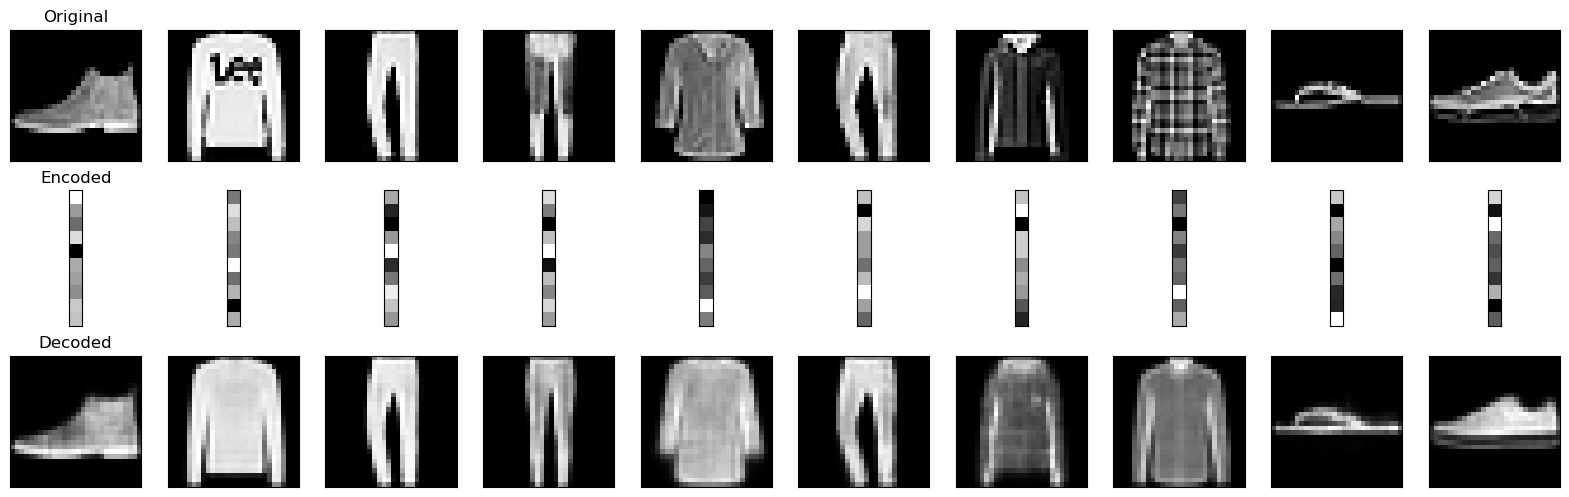

In [12]:
# Plot original, encoded, and decoded images
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Original')

    # Encoded images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(-1, 1))  
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Encoded')

    # Decoded images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title('Decoded')
plt.show()

**Enhanced Handling of Uncertainty:**

- The probabilistic nature of the VAE allows it to capture and quantify **uncertainty** in the data. This is particularly beneficial in scenarios where uncertainty estimation is important, such as in generative modeling and representation learning tasks.

# Saving the Model

**Model Saving**:
   - The trained VAE model is saved for future use.

In [13]:
# Save the model
vae.save("improved_vae_model.h5")

C:\Users\Karma\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Comparison

- The shift from a **normal autoencoder** to a **VAE** adds several important features, especially for generative models. 

- The VAE encodes inputs into **mean-variance distributions**, creating randomness in latent space unlike a normal autoencoder.

- A probabilistic interpretation allows sampling for **data production**. The VAE has a **`Sampling` layer** to introduce **variability** during training. 

- VAE loss functions combine **reconstruction loss and KL divergence** as a **regularization** term to fit the **latent space** to a standard normal distribution.

- Architecturally, the VAE encoder outputs probability distribution parameters, requiring the **Sampling layer**. 

- VAEs can now do **generative** tasks effectively, making them appropriate for **image generation** and areas such as drug discovery. 

- The VAE's **probabilistic** methodology improves its **resilience, adaptability, and generative powers over a standard autoencoder.**